In [15]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import modgp
import GPflow

In [16]:
#%% 
def logistic(x):
    return 1./(1+ np.exp(-x))

def softmax(x,y,z):
    Nor = np.exp(x) + np.exp(y) + np.exp(z)
    return np.exp(x)/Nor, np.exp(y)/Nor, np.exp(z)/Nor

In [17]:
sfrec = 16000 #sampling frequency
sper  = 1./sfrec 
a = 0. #initial time instant
b = 0.02 # final time instant
X = np.linspace(a, b-sper, 320).reshape(-1, 1) # get 20 miliseconds of signal (sample rate = 16kHz)

frec1 = 880;
f_1 = np.sin(2*np.pi*frec1*X)

frec2 = 293.66;
f_2 = np.sin(2*np.pi*frec2*X)



k_i  = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec1))
k_j  = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec1))
k_l  = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec1))
k_f1 = k_i + k_j + k_l


k_a  = GPflow.kernels.Cosine(input_dim = 1, variance=1.0,  lengthscales=1./(2*np.pi*frec2))
k_b  = GPflow.kernels.Cosine(input_dim = 1, variance=0.5,  lengthscales=1./(2*2*np.pi*frec2))
k_c  = GPflow.kernels.Cosine(input_dim = 1, variance=0.25, lengthscales=1./(3*2*np.pi*frec2))
k_f2 = k_a + k_b + k_c


k_g1 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.011, variance=20)
k_g2 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.012, variance=20)
k_g3 = GPflow.kernels.Matern52(input_dim=1, lengthscales=0.013, variance=20)

K_g1 = k_g1.compute_K_symm(X)
K_g2 = k_g2.compute_K_symm(X)
K_g3 = k_g3.compute_K_symm(X)

K_f1 = k_f1.compute_K_symm(X)
K_f2 = k_f2.compute_K_symm(X)


noise_var = 0.001
np.random.seed(6)

g_1 = np.random.multivariate_normal(np.zeros(X.shape[0]), K_g1).reshape(-1, 1)
g_2 = np.random.multivariate_normal(np.zeros(X.shape[0]), K_g2).reshape(-1, 1)
g_3 = np.random.multivariate_normal(np.zeros(X.shape[0]), K_g3).reshape(-1, 1)

#%%
g_sig_1, g_sig_2, g_sig_3 = softmax(g_1,g_2,g_3)

mean = g_sig_1*f_1 + g_sig_2*f_2 + g_sig_3*0

y = mean + np.random.randn(*mean.shape) * np.sqrt(noise_var)

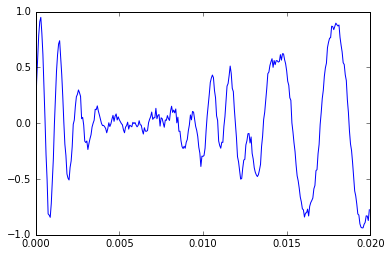

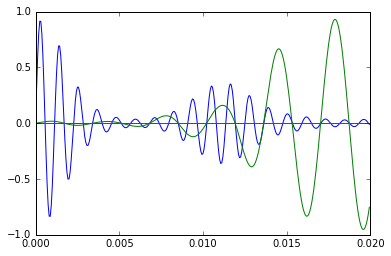

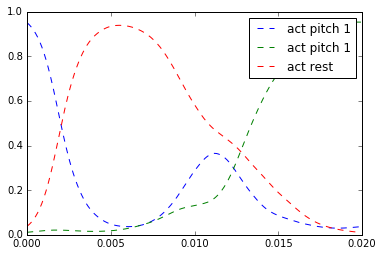

In [18]:
plt.figure()
plt.plot(X,y)
plt.figure()
plt.plot(X,g_sig_1*f_1)
plt.plot(X,g_sig_2*f_2)
plt.plot(X,g_sig_3*0)


plt.figure()
plt.plot(X,g_sig_1,'--')
plt.plot(X,g_sig_2,'--')
plt.plot(X,g_sig_3,'--')
plt.legend(['act pitch 1','act pitch 1','act rest'])